# Evaluating topic coherence

Typical approach to evaluating topic coherence measures involve human ratings of LDA topics. 
Dataset modeled is often generic enough to for raters from Amazon mechanical Turk to be familiar with the vocabulary and ideas (News, Wikipedia, etc) </br>
[Newman, Lau. Automatic Evaluation of topic coherence](https://dl.acm.org/citation.cfm?id=1858011) </br>
Not too complicated to decide on a coherence measure with this approach -- retrieve a coherence score using various metrics and see which correlates best with human ratings:

In [2]:
import os
from gensim.corpora import Dictionary
from process_topics import show_topic_words, run_all, coherence_widget, NewCoherence, coherence_scores
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from IPython.display import Image


In [1]:
plots = []
with open('../data/movieplotsawk') as f:
    plots =f.readlines()
plots = [i.split() for i in plots]
dictionarymovie = Dictionary(plots)
corpusmovie = [dictionarymovie.doc2bow(text) for text in plots]

tf_vectorizer = CountVectorizer()
tftexts = [' '.join(text) for text in plots]
tf = tf_vectorizer.fit_transform(tftexts)
tf[tf>1]=1
xc = (tf.T * tf)
cooccur =xc.todense()

In [2]:
tmfile =open('../data/topicsMovie.txt')
topicsmovie = [i.rstrip('\n').split() for i in tmfile.readlines()]

In [4]:
print dictionarymovie.keys()[:10]
print dictionarymovie[371]

NameError: name 'dictionarymovie' is not defined

In [ ]:

what= coherence_scores(coherence='all', corpus= corpusmovie, 
                       dictionary =dictionarymovie, topics= topicsmovie,
                      cooccur=cooccur, tf_vectorizer=tf_vectorizer)

In [3]:
tmgold = open('../data/goldMovie.txt')
ratingsmovie = [float(i.rstrip('\n')) for i in tmgold.readlines()]
ratingsdict = {"ratings": ratingsmovie}
ratingsdf = pd.DataFrame(ratingsdict)
ratingsandcoherence =pd.concat([ratingsdf,pd.DataFrame(what)], axis =1)

display(ratingsandcoherence.sort_values('ratings'))

NameError: name 'what' is not defined

A few issues with this: </br>
A) Domain/Rater mismatch</br>
B) Loss of judgment information</br>
C) Model type</br>

The ideal simple structure is such that:

-each item has a high, or meaningful, loading on one factor only and

-each factor have high, or meaningful, loadings for only some of the items.

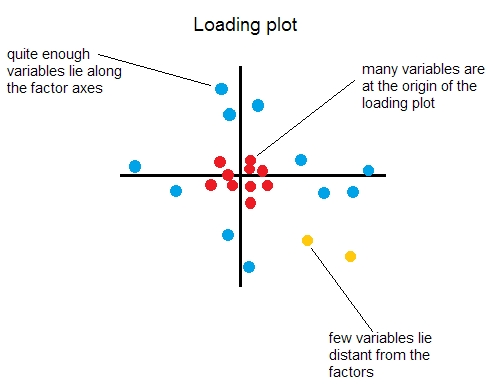

In [9]:
Image(filename='../data/JGplo.jpg') 

In [12]:
%load_ext autoreload
%autoreload 2
import logging
import warnings
import numpy as np
import pandas as pd
import io
from process_topics import show_topic_words, run_all, coherence_widget, NewCoherence, coherence_scores
from gensim.models import CoherenceModel, LdaModel, HdpModel, nmf, LdaMulticore
from gensim.corpora import Dictionary, csvcorpus
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import *
from time import time
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed, interactive_output, FloatSlider
import ipywidgets as widgets
import qgrid
import logging

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up corpus

#### Set up test corpus, should be tokenized, sotpwords removed

In [13]:
%%time

elections = io.open('../data/Election2008Paragraphes.txt',encoding = "ISO-8859-1")
electionlines  =elections.readlines()

CUSTOM_FILTERS = [lambda x: x.lower(),  strip_punctuation, strip_multiple_whitespaces, strip_numeric,remove_stopwords, strip_short]

texts = [preprocess_string(line, filters=CUSTOM_FILTERS) for line in electionlines]


dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

tf_vectorizer = CountVectorizer()
tftexts = [' '.join(text) for text in texts]
tf = tf_vectorizer.fit_transform(tftexts)
tf[tf>1]=1
xc = (tf.T * tf)
cooccur =xc.todense()

data = [texts, dictionary, corpus, tf_vectorizer, tf, cooccur]


CPU times: user 4.16 s, sys: 953 ms, total: 5.12 s
Wall time: 5.4 s


In [48]:
#changes made to FARotate in the code will require kernel restart if reloading this cell!
m = coherence_widget(data)
display(m)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KFJhZGlvQnV0dG9ucyhkZXNjcmlwdGlvbj11J0Nob29zZSBNb2RlbCcsIGxheW91dD1MYXlvdXQod2lkdGg9dScyNTBweCcpLCBvcHRpb25zPSgnTk1GJyzigKY=


In [50]:
topics, coherences, both= m.result

In [51]:
pd.DataFrame(both)

,Topic,association,chisquare,cosine,dice,gmean,inclusion,jaccard,joint_prob,log_cond,npmi,pmi,zscore
0,care health insurance plan costs quality americans families companies veterans,0.0599,0.1658,0.6541,0.0919,0.1985,0.2863,0.1096,0.9086,-1.6613,0.3018,10.6640,15.9541
1,america world people today global energy nation future work like,0.0195,0.0542,0.5692,0.0603,0.1293,0.1835,0.0650,1.1678,-1.9024,0.0950,9.6724,4.7287
2,need energy world oil security change national nuclear military time,0.0152,0.0512,0.5107,0.0498,0.1055,0.1444,0.0537,0.6506,-2.2207,0.0955,9.7080,4.4999
3,people know american want going think good said got like,0.0206,0.0610,0.5821,0.0615,0.1309,0.1816,0.0667,1.1151,-1.8244,0.1132,9.7639,5.4882
4,government american federal people security economy way time trust spending,0.0173,0.0513,0.5507,0.0501,0.1114,0.1754,0.0543,0.8656,-2.1585,0.0993,9.7224,4.6391
5,iraq troops military war iran president qaeda afghanistan security plan,0.0309,0.1112,0.5661,0.0681,0.1505,0.2330,0.0755,0.7036,-1.9645,0.2257,10.3745,10.6489
6,president country want states believe time united going change thank,0.0265,0.0549,0.5416,0.0597,0.1246,0.1614,0.0684,0.9408,-2.0022,0.0955,9.6737,5.1170
7,war time world years like bush end going said americans,0.0134,0.0412,0.5367,0.0536,0.1101,0.1344,0.0571,0.8205,-2.1124,0.0819,9.6372,3.7495
8,tax jobs families help taxes workers americans working middle economy,0.0238,0.1047,0.6181,0.0708,0.1454,0.1786,0.0770,0.6680,-1.9576,0.2252,10.3754,10.0854
9,new energy jobs create nuclear york years like time use,0.0202,0.0689,0.5346,0.0514,0.1146,0.1838,0.0560,0.6821,-2.4087,0.1178,9.7627,6.2139


In [47]:
from __future__ import division
from process_topics import coherence_scores
from similarity import *
style = {'width': '1000px', 'height': '30px'}

w=IntSlider(10,0,1000, description = 'w',layout=style)
w2=IntSlider(10,0,1000, description = 'w2',layout=style) 
co=IntSlider(10,0,1000, description = 'co',layout=style)
ndocs=IntSlider(1000,0,10000, description = 'ndocs',layout=style)
print co.value
exp = FloatSlider(value=0.0, min=0, max=20, description='exp', layout=style)
joint = FloatSlider(value=0.0, min=0, max=20, description='exp', layout=style)

exp.style.handle_color= 'yellow'
#print widgets.__dict__
ui = widgets.VBox([w, w2, co, ndocs,exp])

dummycoprofiles = [[0,1]],[[0,1]]    
def similarities(w,w2,co,ndocs, held=[]):
    scores = calculate_sims(w,w2,co,dummycoprofiles,ndocs,'all')
    #held.append(w)
    display(pd.DataFrame(scores))
    return scores

out =interactive_output(similarities,
         {'w':w,'w2':w2,'co':co,'ndocs':ndocs})

out.layout.height= '500px'
display(ui,out)

@out.capture()
def set_exp_per_rest(change):
    exp.value = ((w.value+ w2.value)/ ndocs.value) *100
    
w.observe(set_exp_per_rest, names="value")
w2.observe(set_exp_per_rest, names="value")
co.observe(set_exp_per_rest, names="value")
ndocs.observe(set_exp_per_rest, names="value")


    

10


VkJveChjaGlsZHJlbj0oSW50U2xpZGVyKHZhbHVlPTEwLCBkZXNjcmlwdGlvbj11J3cnLCBsYXlvdXQ9TGF5b3V0KGhlaWdodD11JzMwcHgnLCB3aWR0aD11JzEwMDBweCcpLCBtYXg9MTAwMCnigKY=


Output(layout=Layout(height=u'500px'))

In [2]:
import os

plots = []
with open('../data/movieplotsawk') as f:
    plots =f.readlines()


plots = [i.split() for i in plots]
dictionarymovie = Dictionary(plots)
corpusmovie = [dictionarymovie.doc2bow(text) for text in plots]

dictionarymovie.token2id['strip']


In [33]:

tmfile =open('../data/topicsMovie.txt')
topicsmovie = [i.rstrip('\n').split() for i in tmfile.readlines()]


#moviecoherence = coherence_scores(coherence='all', corpus= corpusmovie, dictionary =dictionarymovie, topics= topicsmovie)
what= coherence_scores(coherence='all', corpus= corpusmovie, dictionary =dictionarymovie, topics= topicsmovie)



tmgold = open('../data/goldMovie.txt')
ratingsmovie = [float(i.rstrip('\n')) for i in tmgold.readlines()]
ratingsdict = {"ratings": ratingsmovie}
ratingsdf = pd.DataFrame(ratingsdict)
ratingsandcoherence =pd.concat([ratingsdf,pd.DataFrame(what)], axis =1)

display(ratingsandcoherence.sort_values('ratings'))

In [21]:
display(pd.DataFrame(what))

AttributeError: 'list' object has no attribute 'update'